# DQN Project Part 3

Code runs through until completion

## Contributors: 
- Tadhg Ryan (21310408)
- Craig Phayer (21340633)
- Thomas McCarty (21327696)


In [1]:
# %pip install --upgrade pip
# %pip install -q -U gymnasium swig
# %pip install gymnasium[atari]==0.29.1
# %pip install gymnasium[classic_control,box2d,accept-rom-license,ActionWrapper]==0.29.1
# %pip install tensorflow==2.10
# %pip install "numpy<2"
# %pip install matplotlib
# %pip install opencv-python
# %pip install moviepy

In [2]:
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs available:")
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("Name:", details.get('device_name', 'Unknown GPU'))
else:
    print("No GPU available.")

print(tf.__version__)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # set gpu 0 as default
# Suppressing TensorFlow's informational and warning logs to avoid output clutter.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only GPU 1
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPUs available:
Name: NVIDIA GeForce RTX 4060
2.10.0


In [3]:
# Importing libraries
import gymnasium as gym

# Creating the environment
env = gym.make("ALE/Qbert-v5", obs_type="ram", frameskip=4) # TODO: Check render_mode, env.reset(seed=seed)

# Inspecting the environment
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

Action space: Discrete(6)
Observation space: Box(0, 255, (128,), uint8)


In [4]:
import numpy as np
import cv2
from collections import deque

frame_stack = deque(maxlen=4)

def reset_env_with_stack(env):
    state, info = env.reset(seed=42)
    for _ in range(4):
        frame_stack.append(state)
    return np.stack(frame_stack, axis=-1), info

def step_env_with_stack(env, action):
    next_state, reward, done, truncated, info = env.step(action)
    frame_stack.append(state)
    return np.stack(frame_stack, axis=-1), reward, done, truncated, info

state, _ = env.reset(seed=42)
print("Processed frame shape:", state.shape)

Processed frame shape: (128,)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the DQN model
def create_dqn(action_space):
    model = models.Sequential([
        layers.Input(shape=(128, 4)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(action_space, activation='linear')
    ])
    return model

# Initialize the model
dqn_model = create_dqn(env.action_space.n)
dqn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33,222
Trainable params: 33,222
Non-trainable params: 0
_________________________________________________________________


In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

    def size(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(capacity=50000)

In [7]:
import random

def select_action(model, state, epsilon, action_space):
    if random.random() < epsilon:
        return random.randint(0, action_space - 1)  # Random action
    else:
        q_values = model.predict(state[None, ...], verbose=0)
        return np.argmax(q_values)

In [8]:
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

def record_gameplay(env, model, video_path="trained_agent_gameplay.mp4"):
    recorder = VideoRecorder(env, video_path)

    frame_stack = deque(maxlen=4)

    state, info = env.reset(seed=42)
    
    for _ in range(4):
        frame_stack.append(state)

    state = np.stack(frame_stack, axis=-1)

    for _ in range(500):
        action = np.argmax(model.predict(state[None, ...], verbose=0))

        next_state, reward, done, truncated, info = env.step(action)

        recorder.capture_frame()

        frame_stack.append(next_state)
        state = np.stack(frame_stack, axis=-1)

        if done:
            break
    
    recorder.close()
    recorder.enabled = False
    print(f"Gameplay recorded at recordings/{video_path}")


In [9]:
from gymnasium.core import Wrapper
class CustomRewardWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)

        # Adjust the reward
        reward = self.custom_reward_function(reward, info)

        return state, reward, done, truncated, info

    @staticmethod
    def custom_reward_function(reward, info):
        """
        Custom reward function for Q*bert based on game rules and survival.
        """
        # Base reward remains unchanged
        adjusted_reward = reward

        # Penalize for life loss
        if "lives" in info and info["lives"] < 4:  # Adjust for the initial number of lives
            adjusted_reward -= 50 * (4 - info["lives"])  # Penalize for each lost life

        # Bonus for positive actions
        if reward > 0:
            adjusted_reward += 25  # Add bonus for positive rewards

        if "cube_color_changed" in info:
            adjusted_reward += 10  # Reward for changing cube color

        if "cube_destination_reached" in info:
            adjusted_reward += 50  # Higher reward for achieving destination color

        if "cube_reverted" in info:
            adjusted_reward -= 15  # Penalize for regressing progress

        if "level_completed" in info:
            adjusted_reward += 1000  # Large reward for completing the level
            adjusted_reward += max(0, 200 - info.get("steps", 0))  # Bonus for efficiency

        if "avoided_enemy" in info:
            adjusted_reward += 10  # Bonus for avoiding an enemy

        if "caught_green_ball" in info:
            adjusted_reward += 50  # Bonus for catching the green ball

        if "coily_defeated" in info:
            adjusted_reward += 100  # Reward for defeating Coily

        if info.get("no_op", False) or info.get("fire", False):
            adjusted_reward -= 1

        # Scaling factor to increase reward over time
        scaling_factor = info.get("episode", 0) / 100
        adjusted_reward += scaling_factor * adjusted_reward

        return adjusted_reward

env = CustomRewardWrapper(env)

In [10]:
def soft_decay_interpolation(t, a, b, k=10):
    return b - (b - a) / (1.0 + np.exp(k * (t - 0.5)))

def train_dqn(env, model, target_model, replay_buffer, episodes=500, batch_size=32, gamma=0.99, epsilon_min=0.1, epsilon_max=1, update_target=10, verbose=0):
    """
    Train the DQN model using survival-based rewards.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss_fn = tf.keras.losses.Huber()
    rewards_history = []
    epsilon = epsilon_max

    for episode in range(episodes):
        state, _ = reset_env_with_stack(env)
        total_reward = 0
        episode_loss = 0
        total_lives = 4

        for step in range(10_000):  # Limit steps per episode
            action = select_action(model, state, epsilon, env.action_space.n)
            next_state, reward, done, truncated, info = step_env_with_stack(env, action)

            # Store adjusted reward in replay buffer
            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if replay_buffer.size() > batch_size:
                # Sample from the replay buffer
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size=batch_size)

                # Double DQN: Use the model to select actions, but the target model to evaluate Q-values
                next_q_actions = np.argmax(model.predict(next_states, verbose=verbose), axis=1)
                next_q_values = target_model.predict(next_states, verbose=verbose) # TODO: Print out q values
                target_q_values = rewards + gamma * next_q_values[np.arange(batch_size), next_q_actions] * (1 - dones)

                with tf.GradientTape() as tape:
                    q_values = model(states)
                    q_values = tf.reduce_sum(q_values * tf.one_hot(actions, env.action_space.n), axis=1)
                    loss = loss_fn(target_q_values, q_values)
                    episode_loss += loss.numpy()

                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if done or truncated or info.get("lives") < total_lives:
                break


        # Update target model weights periodically
        if episode % update_target == 0:
            target_model.set_weights(model.get_weights())

        rewards_history.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward:.2f}, Survival Time: {step}, Epsilon: {epsilon:.3f}")
        
        epsilon = soft_decay_interpolation(episode/(episodes-1), epsilon_max, epsilon_min)

    return rewards_history

target_model = create_dqn(env.action_space.n)
target_model.set_weights(dqn_model.get_weights())  # Synchronize weights

rewards_history = train_dqn(
    env=env,
    model=dqn_model,
    target_model=target_model,
    replay_buffer=replay_buffer,
    episodes=500,  # Adjust for quick testing
    batch_size=32,
    gamma=0.75,
    epsilon_min=0.1,
    epsilon_max=1.0,
    update_target=10, # TODO: Test varying this
    verbose=0
)
print("Training complete!")


Episode 1/500, Reward: 50.00, Survival Time: 65, Epsilon: 1.000
Episode 2/500, Reward: 0.00, Survival Time: 60, Epsilon: 0.994
Episode 3/500, Reward: -50.00, Survival Time: 49, Epsilon: 0.994
Episode 4/500, Reward: -50.00, Survival Time: 50, Epsilon: 0.994
Episode 5/500, Reward: 675.00, Survival Time: 143, Epsilon: 0.994
Episode 6/500, Reward: -50.00, Survival Time: 49, Epsilon: 0.993
Episode 7/500, Reward: -50.00, Survival Time: 49, Epsilon: 0.993
Episode 8/500, Reward: 0.00, Survival Time: 60, Epsilon: 0.993
Episode 9/500, Reward: 675.00, Survival Time: 154, Epsilon: 0.993
Episode 10/500, Reward: 0.00, Survival Time: 60, Epsilon: 0.993
Episode 11/500, Reward: -50.00, Survival Time: 49, Epsilon: 0.993
Episode 12/500, Reward: 150.00, Survival Time: 80, Epsilon: 0.993
Episode 13/500, Reward: 50.00, Survival Time: 68, Epsilon: 0.993
Episode 14/500, Reward: 50.00, Survival Time: 69, Epsilon: 0.992
Episode 15/500, Reward: 200.00, Survival Time: 86, Epsilon: 0.992
Episode 16/500, Reward: -5

In [11]:
record_gameplay(env, dqn_model, video_path="trained_agent_gameplay.mp4")

DependencyNotInstalled: moviepy is not installed, run `pip install moviepy`

In [12]:
# Save the model's weights
dqn_model.save_weights("models/dqn_model_weights.h5")
print("Model weights saved!")

Model weights saved!


In [13]:
# Save the entire model
dqn_model.save("models/dqn_model.h5")
print("Model saved!")

Model saved!


In [14]:
def evaluate_agent(env, model, episodes=10):
    total_rewards = []
    for episode in range(episodes):
        state, _ = reset_env_with_stack(env)
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(model.predict(state[None, ...], verbose=0))
            next_state, reward, done, truncated, _ = step_env_with_stack(env, action)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}, Reward: {total_reward}")

    print(f"Average Reward: {np.mean(total_rewards)}")

evaluate_agent(env, dqn_model, episodes=3)

Episode 1, Reward: -22300.0
Episode 2, Reward: -22300.0
Episode 3, Reward: -22300.0
Average Reward: -22300.0


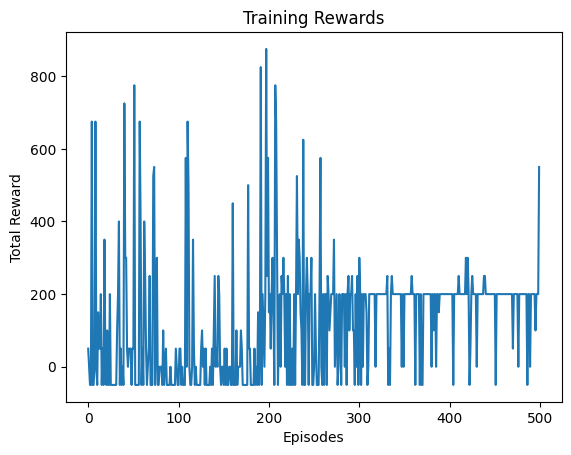

In [15]:
import matplotlib.pyplot as plt

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards')
    plt.show()

# Example
plot_rewards(rewards_history)


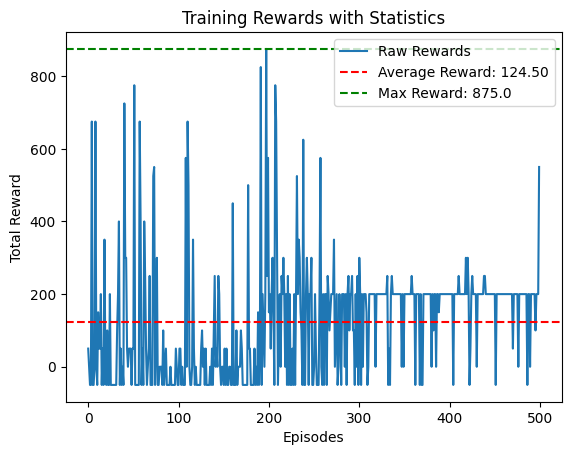

In [16]:
# Calculate key statistics
average_reward = np.mean(rewards_history)
max_reward = np.max(rewards_history)

# Plot the rewards with highlights
plt.plot(rewards_history, label="Raw Rewards")
plt.axhline(average_reward, color='r', linestyle='--', label=f"Average Reward: {average_reward:.2f}")
plt.axhline(max_reward, color='g', linestyle='--', label=f"Max Reward: {max_reward}")
plt.title("Training Rewards with Statistics")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()
plt.show()


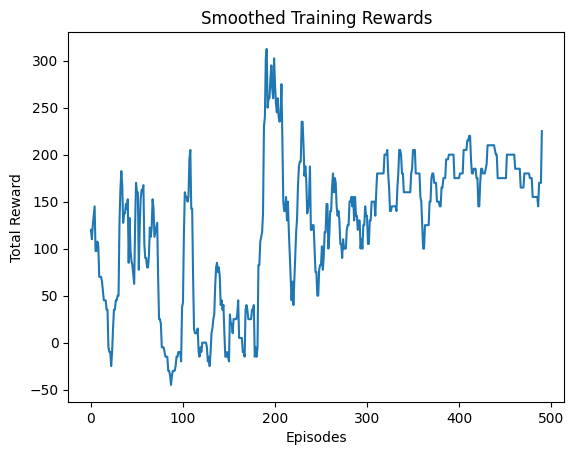

In [17]:
window = 10  # Adjust the window size as needed
smoothed_rewards = np.convolve(rewards_history, np.ones(window)/window, mode='valid')

# Plot smoothed rewards
plt.plot(smoothed_rewards)
plt.title("Smoothed Training Rewards")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()

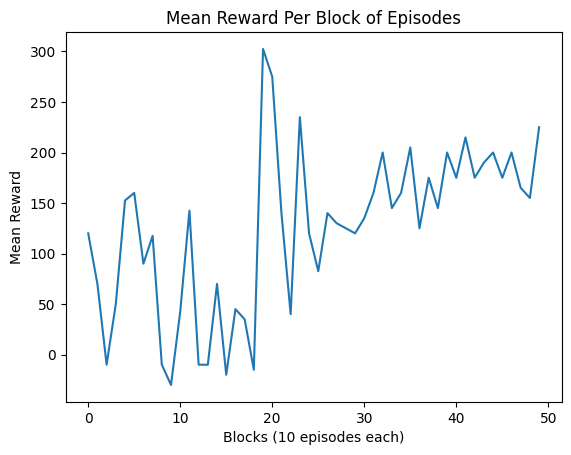

In [18]:
# Segment rewards into blocks
block_size = 10
block_means = [np.mean(rewards_history[i:i+block_size]) for i in range(0, len(rewards_history), block_size)]

# Plot block means
plt.plot(block_means)
plt.title("Mean Reward Per Block of Episodes")
plt.xlabel("Blocks (10 episodes each)")
plt.ylabel("Mean Reward")
plt.show()


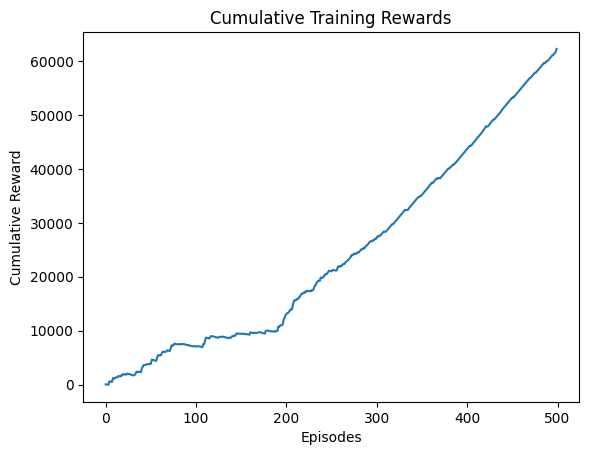

In [19]:
# Calculate cumulative rewards
cumulative_rewards = np.cumsum(rewards_history)

# Plot cumulative rewards
plt.plot(cumulative_rewards)
plt.title("Cumulative Training Rewards")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()
